##<b><u>Project Title : Sentiment Analysis : Predicting sentiment of COVID-19 tweets</u></b>

## <b> Problem Description </b>

### This challenge asks you to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then.

### The names and usernames have been given codes to avoid any privacy concerns.

### You are given the following information:
1. Location
2. Tweet At
3. Original Tweet
4. Label

##**Importing Libraries**

In [1]:
# Importing libraries
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error,classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb

import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# loading csv file in tweet_data dataframe
tweet_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/sentiment analysis/Coronavirus Tweets.csv',encoding='latin')

## **Exploratory Data Analysis**

In [3]:
#how many rows and columns in dataset
tweet_data.shape

(41157, 6)

in this dataset total 6 columns and 41157 rows(data points) are present 

In [4]:
# details information about dataset
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [5]:
#first 10 datapoints of dataset.
tweet_data.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,"As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and ot...",Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,"Cashier at grocery store was sharing his insights on #Covid_19 To prove his credibility he commented ""I'm in Civics class so I know what I'm talking about"". https://t.co/ieFDNeHgDO",Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toilet paper. #Rebel\r\r\n\r\r\n#toiletpapercrisis #covid_19 https://t.co/eVXkQLIdAZ,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,"Due to COVID-19 our retail store and classroom in Atlanta will not be open for walk-in business or classes for the next two weeks, beginning Monday, March 16. We will continue to process online a...",Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our h...",Negative


In [6]:
# Unique numbers of every column datapoints
tweet_data.nunique()

UserName         41157
ScreenName       41157
Location         12220
TweetAt             30
OriginalTweet    41157
Sentiment            5
dtype: int64

###**Details Features information**

* **UserName**: This is the username(encoded in number) unique for every datapoints
* **ScreenName**: This is the ScreenName(encoded in number) unique for every datapoints
* **Location**: places wherefrom tweets are comming
* **TweetAt**: date of tweets data collected
* **OriginalTweet**: Original tweets are stored (This feature is more important in our analysis)
* **Sentiment**: types of sentiment (Positive, Negative, Neutral, Extremely Positive, Extremely Negative) it is dependent variable.


 UserName and ScreenName features are not useful in our analysis, let's drop them

In [7]:
#dropping UserName and ScreenName features
tweet_data = tweet_data.drop(['UserName', 'ScreenName'], axis=1)

In [8]:
#checking duplicate rows 
tweet_data.duplicated().sum()

0

no duplicate rows in dataset

In [9]:
#checking null value in dataset
tweet_data.isnull().sum()

Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [10]:
#calculating null value percentage in location feature
tweet_data['Location'].isna().sum()/len(tweet_data) *100

20.87129771363316

* in Location feature have 8590 null value present that is 20.8% But this feature is not important for our sentiment analysis. Hence we will neglect these null values and no nead to treat null value for our analysis

##**Exploring All Features**

In [11]:
#checking unique value feature-wise
tweet_data.nunique()

Location         12220
TweetAt             30
OriginalTweet    41157
Sentiment            5
dtype: int64

*  ### **Location**

In [12]:
#top 10 location wise tweets
top_10_loc = tweet_data['Location'].value_counts().head(10)
top_10_loc_df = pd.DataFrame(top_10_loc)
top_10_loc_df.reset_index(inplace=True)
top_10_loc_df = top_10_loc_df.rename(columns={'index':'Location', 'Location':'Tweet_count'})
top_10_loc_df

,Location,Tweet_count
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
5,United Kingdom,337
6,"Los Angeles, CA",281
7,India,268
8,UK,232
9,Australia,225


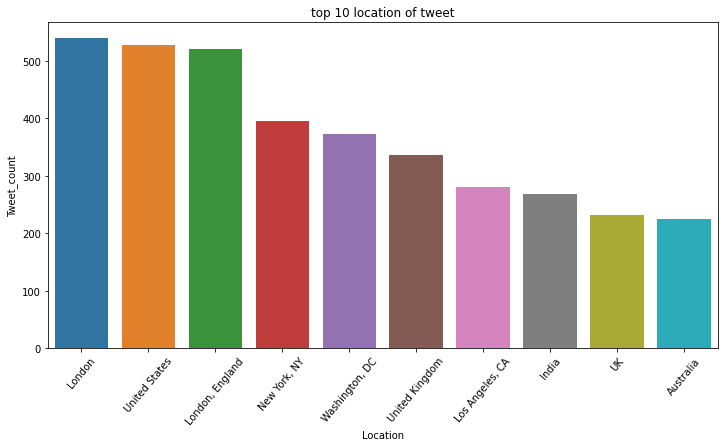

In [13]:
#visualize top 10 location wise tweets
plt.subplots(figsize=(12,6))
plt.title('top 10 location of tweet')
sns.barplot('Location','Tweet_count',data = top_10_loc_df)
plt.xticks(rotation = 50)
plt.show()

* most of the tweets comes from London and US

*  ### **TweetAt**

In [14]:
#checking unique value in TweetAt feature
tweet_data['TweetAt'].value_counts()

20-03-2020    3448
19-03-2020    3215
25-03-2020    2979
18-03-2020    2742
21-03-2020    2653
22-03-2020    2114
23-03-2020    2062
17-03-2020    1977
08-04-2020    1881
07-04-2020    1843
06-04-2020    1742
24-03-2020    1480
09-04-2020    1471
13-04-2020    1428
26-03-2020    1277
05-04-2020    1131
10-04-2020    1005
02-04-2020     954
11-04-2020     909
03-04-2020     810
12-04-2020     803
04-04-2020     767
16-03-2020     656
01-04-2020     630
27-03-2020     345
31-03-2020     316
14-04-2020     284
29-03-2020     125
30-03-2020      87
28-03-2020      23
Name: TweetAt, dtype: int64

* all tweets belongs to March and April months of 2020

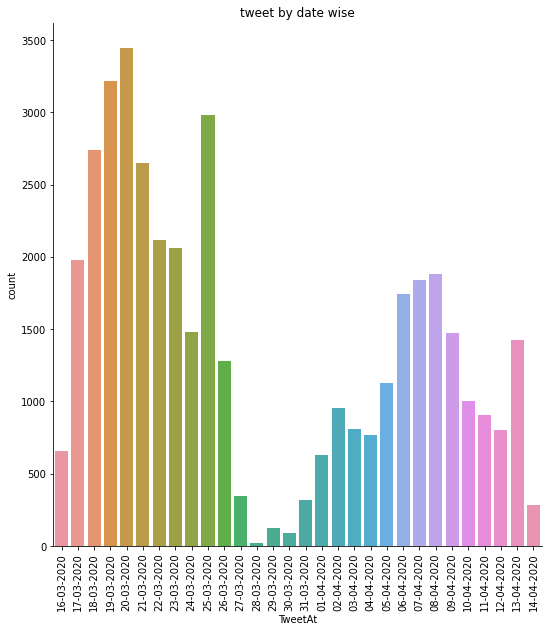

In [15]:
#visualize tweet by date wise
sns.catplot('TweetAt',kind = 'count',height=8,data = tweet_data)
plt.xticks(rotation = 90)
plt.title('tweet by date wise')
plt.show()

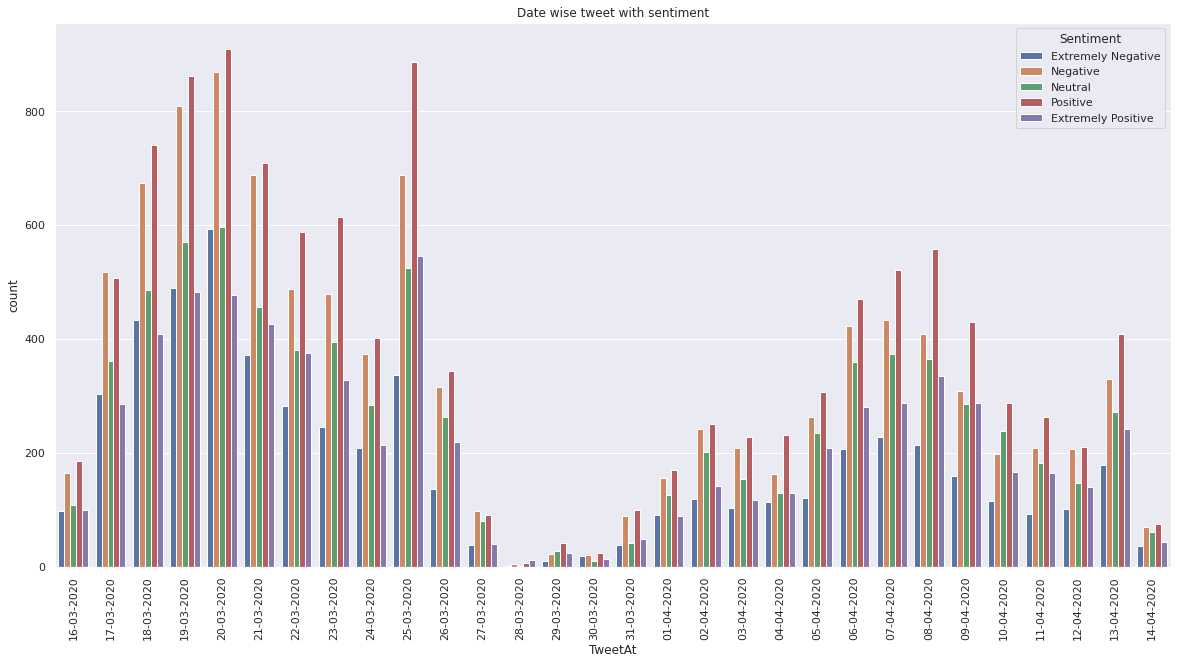

In [16]:
#visualize tweet by date wise with Sentiment
sns.set(rc={'figure.figsize':(20,10)})
sns.countplot('TweetAt',hue='Sentiment',data = tweet_data, hue_order=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'])
plt.title('Date wise tweet with sentiment')
plt.xticks(rotation = 90)
plt.show()


*  ### **Sentiment**

* this feature is our target feature in our analysis

In [17]:
#checking unique value in Sentiment feature
tweet_data['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

* there are five types of Sentiment in this Dataset: 
  Positive,  Negative, Neutral, Extremely Positive, Extremely Negative

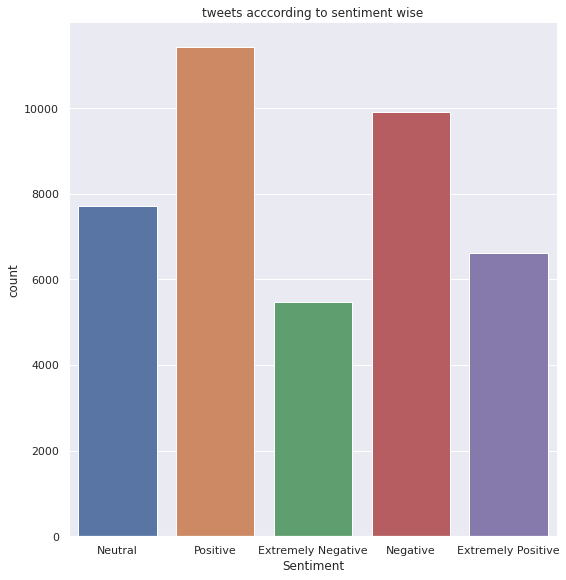

In [18]:
# tweets acccording to sentiment wise
sns.catplot("Sentiment", kind="count", height=8, data=tweet_data)
plt.title("tweets acccording to sentiment wise")
plt.show()

*   ### **Exploring Sentiment type-wise**

In [19]:
#extracting Extremely Negative tweets
tweet_data[tweet_data['Sentiment']=='Extremely Negative']

,Location,TweetAt,OriginalTweet,Sentiment
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative
20,southampton soxx xxx,16-03-2020,with 100 nations inficted with covid 19 the world must not play fair with china 100 goverments must demand china adopts new guilde lines on food safty the chinese goverment is guilty...,Extremely Negative
27,Everywhere You Are!,16-03-2020,"This morning I tested positive for Covid 19. I feel ok, I have no symptoms so far but have been isolated since I found out about my possible exposure to the virus. Stay home people and be pragmat...",Extremely Negative
29,"Someplace, USA",16-03-2020,@7SealsOfTheEnd Soon with dwindling supplies unlawful Panicky people will be breaking into Closed Stores &amp; Supermarkets to Raid them as they normally do during a Crisis so massive as the #Coro...,Extremely Negative
42,Houston,16-03-2020,CHECK VIDEO ?? https://t.co/1ksn9Brl02 ??No food ? in USA market due to coronavirus panic we gonna die from starvation #CoronavirusOutbreak #coronavirus #houston #nofood #Notoiletpaper #NoHandShak...,Extremely Negative
...,...,...,...,...
41115,NaN,14-04-2020,"Food Banks are not equipped for a 30% unemployment rate. The federal government must provide direct aid to everyone, very quickly.\r\r\n\r\r\n""The Coronavirus Food Bank Crisis Is Already Underway""...",Extremely Negative
41128,"Melbourne, Australia",14-04-2020,"The COVID-19 pandemic and global oil price wars are having an economic impact worldwide, but one consequence is lower fuel prices at Australian petrol pumps for the foreseeable.\r\r\n\r\r\n#UniMel...",Extremely Negative
41130,NaN,14-04-2020,Squeo works in the meat department of a Kroger supermarket in Michigan. He knows of several grocery workers whoÂve tested positive for COVID-19 and one in his area who died. He worries that the b...,Extremely Negative
41133,Austria,14-04-2020,A Singaporean politician who slammed a woman snapped with seven supermarket trolleys during COVID-19 lockdown has been forced to eat humble pie after it turned out she was donating goods to the po...,Extremely Negative


In [20]:
#details comment of Extremely Negative Tweet
tweet_data[tweet_data['Sentiment']=='Extremely Negative'].loc[41133,'OriginalTweet']

'A Singaporean politician who slammed a woman snapped with seven supermarket trolleys during COVID-19 lockdown has been forced to eat humble pie after it turned out she was donating goods to the poor\r\r\nhttps://t.co/EDBXXtdHxl\r\r\n#covid19 #lockdown'

In [21]:
#extracting Negative tweets
tweet_data[tweet_data['Sentiment']=='Negative']

,Location,TweetAt,OriginalTweet,Sentiment
9,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our h...",Negative
24,Downstage centre,16-03-2020,@10DowningStreet @grantshapps what is being done to ensure food and other essential products are being re-stocked at supermarkets and panic buying actively discouraged? It cannot be left to checko...,Negative
26,"Ketchum, Idaho",16-03-2020,"In preparation for higher demand and a potential food shortage, The Hunger Coalition purchased 10 percent more food and implemented new protocols due to the COVID-19 coronavirus. https://t.co/5Cec...",Negative
28,"New York, NY",16-03-2020,Do you see malicious price increases in NYC? The NYC Department of Consumer and Worker Protection (DCWP) has set up a page to digitally file a complaint. Click here: https://t.co/oEx6Y8mm2K\r\r\n\...,Negative
30,NaN,16-03-2020,There Is of in the Country The more empty shelves people see the more buying ensues the more food is out of stock,Negative
...,...,...,...,...
41127,NaN,14-04-2020,Today at the grocery store I saw someone getting a case of #Corona beer and I was about to jokingly say 'hey man i see you got Corona' then I stopped myself doing that thinking it would be the new...,Negative
41131,"Accra, Ghana",14-04-2020,"In every human affliction there are gainers and losers. In this case of Covid 19, the TELECOS are gaining beyond expectations. The level of internet being used at this moment is mind blowing. Gov...",Negative
41147,"Brooklyn, NY",14-04-2020,YÂall really shitting that much more at home?? #COVID19 #coronavirus #toiletpaper,Negative
41149,"Toronto, Ontario",14-04-2020,"Still shocked by the number of #Toronto supermarket employees working without some sort of mask. We all know by now, employees can be asymptomatic while spreading #coronavirus .",Negative


In [22]:
#details comment of Negative Tweet
tweet_data[tweet_data['Sentiment']=='Negative'].loc[28,'OriginalTweet']

'Do you see malicious price increases in NYC? The NYC Department of Consumer and Worker Protection (DCWP) has set up a page to digitally file a complaint. Click here: https://t.co/oEx6Y8mm2K\r\r\n\r\r\nTo file a complaint (use the word"Overcharge") https://t.co/MdMmoBttOP\r\r\n#COVID19 #CovidNYC'

In [23]:
#extracting Neutral tweets
tweet_data[tweet_data['Sentiment']=='Neutral']

,Location,TweetAt,OriginalTweet,Sentiment
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
7,Austria,16-03-2020,Was at the supermarket today. Didn't buy toilet paper. #Rebel\r\r\n\r\r\n#toiletpapercrisis #covid_19 https://t.co/eVXkQLIdAZ,Neutral
10,"Makati, Manila",16-03-2020,"All month there hasn't been crowding in the supermarkets or restaurants, however reducing all the hours and closing the malls means everyone is now using the same entrance and dependent on a singl...",Neutral
16,Saudi Arabia,16-03-2020,????? ????? ????? ????? ??\r\r\n?????? ????? ??????? ????????? ?\r\r\n#????_???? ????? ???? ?????? ? #????????? ?????? ?? 13 ???? ?? ?? ???? ?????? ?? ??\r\r\n#???_???????? ????? ??? ???? ? https:...,Neutral
17,"Ontario, Canada",16-03-2020,"@eyeonthearctic 16MAR20 Russia consumer surveillance watchdog reported case in high Arctic where a man who traveled to Iran has COVID-19 and 101 are ""observed""\r\r\nhttps://t.co/4WnrrK9oKC https:/...",Neutral
...,...,...,...,...
41141,India,14-04-2020,#Coronavirus ?? ????? ??? ????? ?? ??? ??????? ?? ????? ???? ?? ?? ??? ??? ?? ??? ?? ??????? ???? ??? ???????????? @narendramodi ?? ??? ????? ?? ????? ???? ?? ????\r\r\n#ATCard #StayHome #Lockdown...,Neutral
41143,In burning hell.,14-04-2020,https://t.co/8s4vKvcO1r #5gtowers?? #EcuadorUnido #cruiseships #SaveTheChildren #wuhan #BillGates?#SocialDistance #coronavirus is caused by #cellpoisoning from #radiation #cancer #exosomes #youcan...,Neutral
41144,NaN,14-04-2020,@_Sunrise_SV @Gamzap @NPR What does not having a supermarket nearby have to do with getting COVID-19?,Neutral
41152,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket shelves in #NZ lockdown #COVID-19 https://t.co/cz89uA0HNp,Neutral


In [24]:
#details comment of Neutral Tweet
tweet_data[tweet_data['Sentiment']=='Neutral'].loc[10,'OriginalTweet']

"All month there hasn't been crowding in the supermarkets or restaurants, however reducing all the hours and closing the malls means everyone is now using the same entrance and dependent on a single supermarket. #manila #lockdown #covid2019 #Philippines https://t.co/HxWs9LAnF9"

In [25]:
#extracting Positive tweets
tweet_data[tweet_data['Sentiment']=='Positive']

,Location,TweetAt,OriginalTweet,Sentiment
1,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive
2,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive
5,"ÃT: 36.319708,-82.363649",16-03-2020,"As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and ot...",Positive
6,"35.926541,-78.753267",16-03-2020,"Cashier at grocery store was sharing his insights on #Covid_19 To prove his credibility he commented ""I'm in Civics class so I know what I'm talking about"". https://t.co/ieFDNeHgDO",Positive
...,...,...,...,...
41140,Pakistan,14-04-2020,Good News! \r\r\nWe'll Soon Announce Our High Tech G&amp;G Online &amp; Live Course for Covid-19 effected Countries in very low prices. \r\r\nTitle: How to Approach Shale Reservoirs\r\r\nSpeaker: ...,Positive
41145,"Manhattan, NY",14-04-2020,How exactly are we going to re-open New York City if we still can't buy any hand sanitizer? #coronavirus,Positive
41146,"Gurgaon, India",14-04-2020,"#Gold prices rose to a more than 7-year high today due to #coronavirus increased bullion's #safe-haven appeal.\r\r\nIt gained 0.1% to $1,715.25/ounce , having touched its highest since Dec. 2012 a...",Positive
41150,OHIO,14-04-2020,"I never that weÂd be in a situation &amp; world that going to the supermarket , picking up a package or my mail is like playing Russian roulette with my life #coronavirus #StayHome #SocialDistancing",Positive


In [26]:
#details comment of Positive Tweet
tweet_data[tweet_data['Sentiment']=='Positive'].loc[1,'OriginalTweet']

'advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order'

In [27]:
#extracting Positive tweets
tweet_data[tweet_data['Sentiment']=='Extremely Positive']

,Location,TweetAt,OriginalTweet,Sentiment
11,"Pitt Meadows, BC, Canada",16-03-2020,"Due to the Covid-19 situation, we have increased demand for all food products. \r\r\n\r\r\nThe wait time may be longer for all online orders, particularly beef share and freezer packs. \r\r\n\r\r\...",Extremely Positive
12,Horningsea,16-03-2020,"#horningsea is a caring community. LetÂs ALL look after the less capable in our village and ensure they stay healthy. Bringing shopping to their doors, help with online shopping and self isolatio...",Extremely Positive
18,North America,16-03-2020,"Amazon Glitch Stymies Whole Foods, Fresh Grocery Deliveries\r\r\nÂAs COVID-19 has spread, weÂve seen a significant increase in people shopping online for groceries,Â a spokeswoman said in a sta...",Extremely Positive
22,NaN,16-03-2020,We have AMAZING CHEAP DEALS! FOR THE #COVID2019 going on to help you???\r\r\n#Trials\r\r\n#Monthly\r\r\n#Yearly \r\r\nAnd Resonable #Prices / #Subscriptions\r\r\nJust DM US! #bestiptv #iptv #Servi...,Extremely Positive
23,NaN,16-03-2020,We have AMAZING CHEAP DEALS! FOR THE #COVID2019 going on to help you???\r\r\n#Trials\r\r\n#Monthly\r\r\n#Yearly \r\r\nAnd Resonable #Prices / #Subscriptions\r\r\nJust DM US! #bestiptv #iptv #Servi...,Extremely Positive
...,...,...,...,...
41137,"LES, NYC",14-04-2020,Distilleries have switched portions of their production from alcohol to hand sanitizer to help with,Extremely Positive
41138,"Los Angeles, CA",14-04-2020,HMU FOR PRICES!! Got great deals going right now. #weedsmokers #StonerFam #420 #bud #Gas #FullSend #Nelkboys #coronavirus #StimulusChecks #ListenToYourHeart https://t.co/mDMgkOQ8m3,Extremely Positive
41142,Juba south sudan,14-04-2020,@MajangChien @MTNSSD @MTNSSD is worst than COVID-19. All businesses have reduced their prices but our MTN is looting us instead of giving us free data.,Extremely Positive
41148,NaN,14-04-2020,"UV light Sterilizer Sanitizer for your mask and mobile phone ?, pls take care, be safe. #sanitizer #sanitizers #corona #coronavirus #coronavÃ­rus #coronavirÃ¼s https://t.co/v8XDXhqeYN",Extremely Positive


In [28]:
#details comment of Extremely Positive Tweet
tweet_data[tweet_data['Sentiment']=='Extremely Positive'].loc[41138,'OriginalTweet']

'HMU FOR PRICES!! Got great deals going right now. #weedsmokers #StonerFam #420 #bud #Gas #FullSend  #Nelkboys #coronavirus #StimulusChecks #ListenToYourHeart https://t.co/mDMgkOQ8m3'

##**Data Preprocessing**


*  ### **Removing pattern**

In [29]:
#function for removing any pattern
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [30]:
#removing @username from OriginalTweet
tweet_data['cleaned_tweet'] = np.vectorize(remove_pattern)(tweet_data['OriginalTweet'], '@[\w]*')

In [31]:
#after removed @username
tweet_data.head()

,Location,TweetAt,OriginalTweet,Sentiment,cleaned_tweet
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
1,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P"
3,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\..."
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don..."


In [32]:
#removing http and url from cleaned_tweet
tweet_data['cleaned_tweet'] = tweet_data['cleaned_tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [33]:
#after removed http and url
tweet_data.head()

,Location,TweetAt,OriginalTweet,Sentiment,cleaned_tweet
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak"
3,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\..."
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don..."


In [34]:
#removing special characters, numbers and punctuations from cleaned_tweet
tweet_data['cleaned_tweet'] = tweet_data['cleaned_tweet'].str.replace('[^a-zA-Z#]+',' ')

In [35]:
#after removed special characters, numbers and punctuations
tweet_data.head()

,Location,TweetAt,OriginalTweet,Sentiment,cleaned_tweet
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,Coronavirus Australia Woolworths to give elderly disabled dedicated shopping hours amid COVID outbreak
3,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,My food stock is not the only one which is empty PLEASE don t panic THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need Stay calm stay safe #COVID france #COVID #COVID #co...
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,Me ready to go at supermarket during the #COVID outbreak Not because I m paranoid but because my food stock is litteraly empty The #coronavirus is a serious thing but please don t panic It causes ...


In [36]:
#removing short words(length less than 3)
tweet_data['cleaned_tweet'] = tweet_data['cleaned_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [37]:
#after removed short words(length less than 3)
tweet_data.head()

,Location,TweetAt,OriginalTweet,Sentiment,cleaned_tweet
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk your neighbours family exchange phone numbers create contact list with phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular med...
2,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,Coronavirus Australia Woolworths give elderly disabled dedicated shopping hours amid COVID outbreak
3,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,food stock not the only one which empty PLEASE don panic THERE WILL ENOUGH FOOD FOR EVERYONE you not take more than you need Stay calm stay safe #COVID france #COVID #COVID #coronavirus #confineme...
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,ready supermarket during the #COVID outbreak Not because paranoid but because food stock litteraly empty The #coronavirus serious thing but please don panic causes shortage #CoronavirusFrance #res...



*  ### **Tokenization and Stemming**

In [38]:
#tokenizing tweet from cleaned_tweet 
tokenized_tweet = tweet_data['cleaned_tweet'].apply(lambda x: x.split())

In [39]:
tokenized_tweet[:5]

0                                                                                                                                                                                                         []
1    [advice, Talk, your, neighbours, family, exchange, phone, numbers, create, contact, list, with, phone, numbers, neighbours, schools, employer, chemist, set, online, shopping, accounts, poss, adequ...
2                                                                                           [Coronavirus, Australia, Woolworths, give, elderly, disabled, dedicated, shopping, hours, amid, COVID, outbreak]
3    [food, stock, not, the, only, one, which, empty, PLEASE, don, panic, THERE, WILL, ENOUGH, FOOD, FOR, EVERYONE, you, not, take, more, than, you, need, Stay, calm, stay, safe, #COVID, france, #COVID...
4    [ready, supermarket, during, the, #COVID, outbreak, Not, because, paranoid, but, because, food, stock, litteraly, empty, The, #coronavirus, serious, thing, but, please, don, p

In [40]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

#apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [41]:
tokenized_tweet[:5]

0                                                                                                                                                                                                         []
1    [advic, talk, your, neighbour, famili, exchang, phone, number, creat, contact, list, with, phone, number, neighbour, school, employ, chemist, set, onlin, shop, account, poss, adequ, suppli, regula...
2                                                                                                        [coronaviru, australia, woolworth, give, elderli, disabl, dedic, shop, hour, amid, covid, outbreak]
3    [food, stock, not, the, onli, one, which, empti, pleas, don, panic, there, will, enough, food, for, everyon, you, not, take, more, than, you, need, stay, calm, stay, safe, #covid, franc, #covid, #...
4    [readi, supermarket, dure, the, #covid, outbreak, not, becaus, paranoid, but, becaus, food, stock, litterali, empti, the, #coronaviru, seriou, thing, but, pleas, don, panic, c

In [42]:
#join all tokens into one sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

In [43]:
#replacing cleaned tweet to tokenized_tweet
tweet_data['cleaned_tweet']  = tokenized_tweet

In [44]:
#after apply tokenized_tweet
tweet_data.head()

,Location,TweetAt,OriginalTweet,Sentiment,cleaned_tweet
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order
2,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak
3,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...


##**Custom Analysis**

*  What are the most common words in the entire dataset?

*  What are the most common words in the dataset for negative and positive tweets, respectively?

*  How many hashtags are there in a tweet?

*  Which trends are associated with my dataset?

*  Which trends are associated with either of the sentiments? Are they compatible with the sentiments?

**What are the most common words in the entire dataset?**

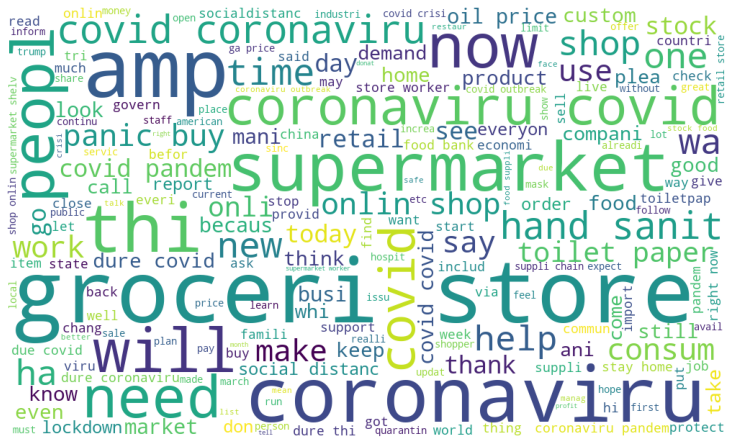

In [45]:
#visualize most common words in the entire dataset
whole_words = ' '.join([text for text in tweet_data['cleaned_tweet']])

#generate a word cloud image
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", width=1000, height=600).generate(whole_words)
plt.figure(figsize=(10,6))
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.show()

**What are the most common words in the dataset for negative and positive tweets, respectively?**

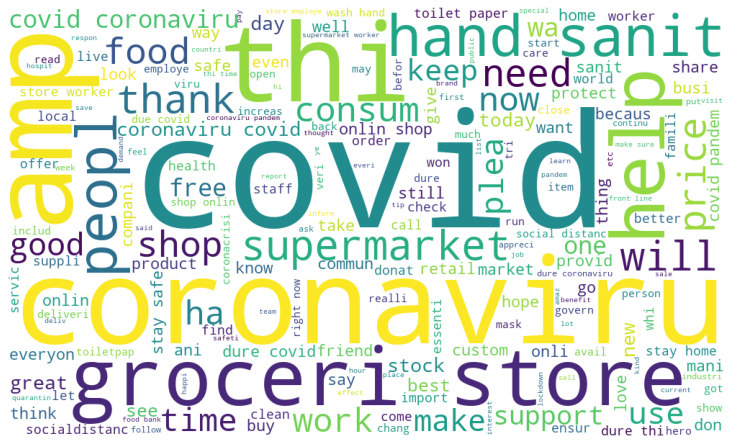

In [46]:
#visualize most common words in the Extremely Positive Sentiment
extreme_positive_words = ' '.join([text for text in tweet_data['cleaned_tweet'][tweet_data.Sentiment == 'Extremely Positive']])

#generate a word cloud image
wordcloud = WordCloud(background_color="white", width=1000, height=600).generate(extreme_positive_words)
plt.figure(figsize=(10,6))
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.show()

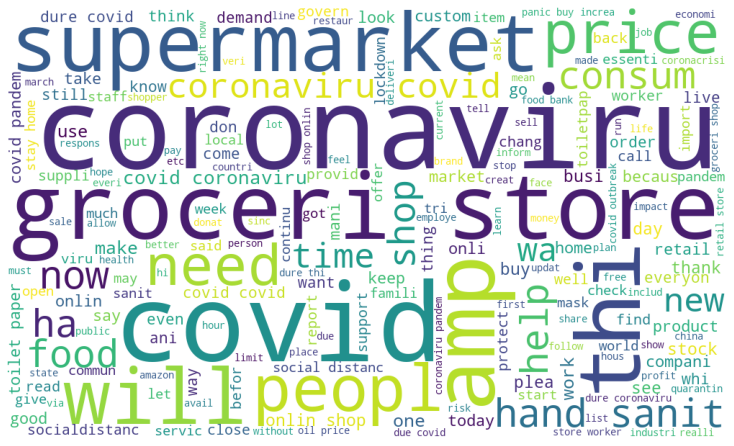

In [47]:
#visualize most common words in the Positive Sentiment
positive_words = ' '.join([text for text in tweet_data['cleaned_tweet'][tweet_data.Sentiment == 'Positive']])

#generate a word cloud image
wordcloud = WordCloud(background_color="white", width=1000, height=600).generate(positive_words)
plt.figure(figsize=(10,6))
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.show()

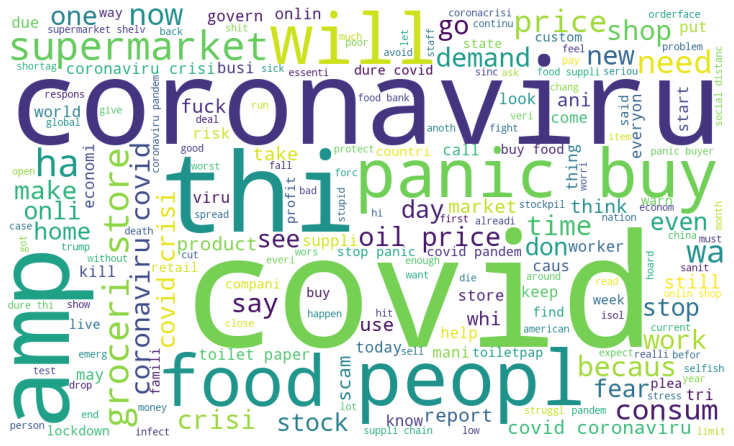

In [48]:
#visualize most common words in the Extremely Negative Sentiment
extreme_negative_words = ' '.join([text for text in tweet_data['cleaned_tweet'][tweet_data.Sentiment == 'Extremely Negative']])

#generate a word cloud image
wordcloud = WordCloud(background_color="white", width=1000, height=600).generate(extreme_negative_words)
plt.figure(figsize=(10,6))
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.show()

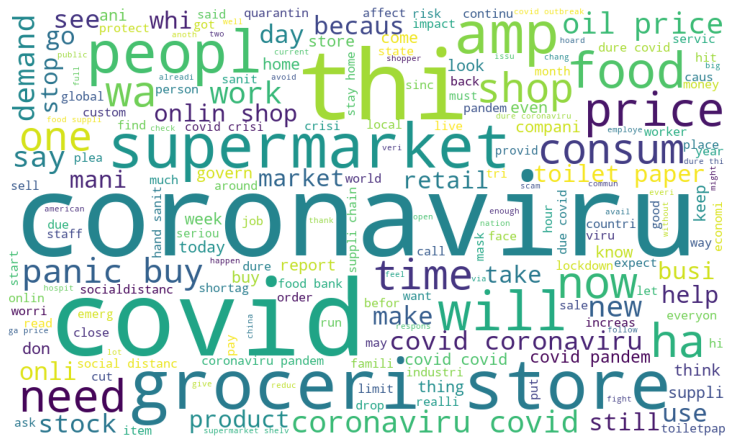

In [49]:
#visualize most common words in the Negative Sentiment
negative_words = ' '.join([text for text in tweet_data['cleaned_tweet'][tweet_data.Sentiment == 'Negative']])

#generate a word cloud image
wordcloud = WordCloud(background_color="white", width=1000, height=600).generate(negative_words)
plt.figure(figsize=(10,6))
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.show()

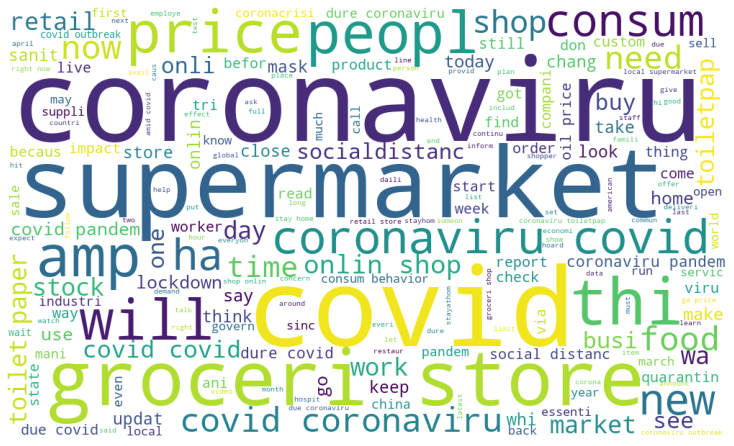

In [50]:
#visualize most common words in the Neutral Sentiment
neutral_words = ' '.join([text for text in tweet_data['cleaned_tweet'][tweet_data.Sentiment == 'Neutral']])

#generate a word cloud image
wordcloud = WordCloud(background_color="white", width=1000, height=600).generate(neutral_words)
plt.figure(figsize=(10,6))
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.show()

 * ### **Hashtag**

In [51]:
#function for extracting hashtags
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
    return hashtags

**How many hashtags are there in a tweet?**

In [52]:
#counting total hashtags in dataset
total_hashtag = hashtag_extract(tweet_data['OriginalTweet'])
total_hashtag = sum(total_hashtag, [])
print(f'{len(total_hashtag)} hashtags in entire dataset')

81151 hashtags in entire dataset


**Which trends are associated with my dataset?**

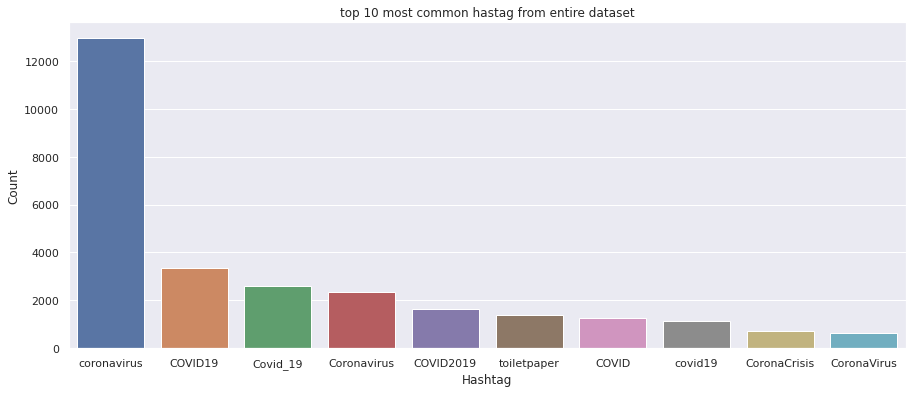

In [53]:
#top 10 most common hastag from entire dataset
hashtag_freq = nltk.FreqDist(total_hashtag)
hashtag_freq_df = pd.DataFrame({'Hashtag': list(hashtag_freq.keys()),'Count' : list(hashtag_freq.values())})
top_10_hashtag_freq = hashtag_freq_df.nlargest(10,'Count')
plt.figure(figsize = (15,6))
sns.barplot('Hashtag','Count', data = top_10_hashtag_freq)
plt.title('top 10 most common hastag from entire dataset')
plt.show()

* clearly seen in the above figure, coronavirus and covid19 trends associated with our dataset

**Which trends are associated with either of the sentiments? Are they compatible with the sentiments?**

In [54]:
#extracting hashtags from OriginalTweet
extreme_positive_hashtag = hashtag_extract(tweet_data['OriginalTweet'][tweet_data.Sentiment == 'Extremely Positive'])
positive_hashtag = hashtag_extract(tweet_data['OriginalTweet'][tweet_data.Sentiment == 'Positive'])
neutral_hastag = hashtag_extract(tweet_data['OriginalTweet'][tweet_data.Sentiment == 'Neutral'])
negative_hashtag = hashtag_extract(tweet_data['OriginalTweet'][tweet_data.Sentiment == 'Negative'])
extreme_negative_hashtag = hashtag_extract(tweet_data['OriginalTweet'][tweet_data.Sentiment == 'Extremely Negative'])

#removing nesting list
extreme_positive_hashtag = sum(extreme_positive_hashtag, [])
positive_hashtag = sum(positive_hashtag, [])
neutral_hastag = sum(neutral_hastag, [])
negative_hashtag = sum(negative_hashtag,[])
extreme_negative_hashtag = sum(extreme_negative_hashtag,[])

In [55]:
print(extreme_positive_hashtag[:100])

['horningsea', 'COVID2019', 'Trials', 'Monthly', 'Yearly', 'Prices', 'Subscriptions', 'bestiptv', 'iptv', 'Service', 'Iptv', 'iptvdeals', 'Cheap', 'ipTV', 'Football', 'HD', 'Movies', 'Adult', 'Cinema', 'hotmovies', 'iptvnew', 'iptv2020', 'Adult', 'COVID2019', 'Trials', 'Monthly', 'Yearly', 'Prices', 'Subscriptions', 'bestiptv', 'iptv', 'Service', 'Iptv', 'iptvdeals', 'Cheap', 'ipTV', 'Football', 'HD', 'Movies', 'Adult', 'Cinema', 'hotmovies', 'ipTv', '18Movies', 'consumer', 'covid19', 'tracker', 'BreakingNews', 'Breaking', 'Coronavirus', 'CoronavirusOutbreak', 'COVID19', 'COVID', 'COVID_19', 'COVID2019', 'Collapse', 'CoronavirusOutbreak', 'coronavirus', 'COVID2019', 'jlmco', 'jlmcobrand', 'coronapocolypse', 'coronavirus', 'CoronavirusOutbreak', 'COVID19', 'shoponline', 'coronavirus', 'COVID19', 'peoplearelosingtheirminds', 'StopTheMadness', 'stoppanicbuying', 'coronavirus', 'StopPanicBuying', 'BeKind', 'mufc', 'MUFC_Family', 'Malaysia2020', 'Malaysia', 'COVID', 'COVID2019', 'Quarantine

In [56]:
print(positive_hashtag[:100])

['COVID19france', 'COVID_19', 'COVID19', 'coronavirus', 'confinement', 'Confinementotal', 'ConfinementGeneral', 'Covid_19', 'CoronaVirus', 'coronavirus', 'covid19', 'COVID19', 'CoronavirusOutbreak', 'COVID2019', 'economy', 'onlineshopping', 'coronavirus', 'covid19', 'stayhome', 'coronavirus', 'COVID19', 'coronapocolypse', 'coronavirus', 'coronavirus', 'LockdownCanada', 'coronavirus', 'Coronavirus', 'COVID19', 'covid19', 'ecommerce', 'omnichannel', 'retail', 'digital', 'coronavirus', 'coronavirus', 'COVID2019', 'StayHealthy', 'coronavirus', 'Covid_19', 'pricegougers', 'Hoarders', 'Idiots', 'panicbuying', 'selfishpeople', 'CoronavirusOutbreak', 'coronavirus', 'COVID', 'COVID19', 'coronapocolypse', 'coronavirus', 'COVID', 'Hoarders', 'groceries', 'panicshopping', 'StopPanicBuying', 'coronavirus', 'COVID2019', 'StaySafe', 'frontlines', 'WINWIN', 'coronavirus', 'stayindoorsandshop', 'coronavirus', 'StopPanicBuying', 'reverselogistics', 'COVID', 'ECommerce', 'Returns', 'Coronavirus', 'panicb

In [57]:
print(neutral_hastag[:100])

['Rebel', 'toiletpapercrisis', 'covid_19', 'manila', 'lockdown', 'covid2019', 'Philippines', 'coronavirus', 'BrickAndMortar', 'COVID2019', 'QuarantineLife', 'CoronavirusOutbreak', 'coronavirus', 'IMadeThisUp', 'FakeNews', 'covid_19', 'pandemic', 'socialdistancing', 'retail', 'seafood', 'coronavirus', 'CoronavirusOutbreak', 'CoronavirusReachesDelhi', 'Coronavid19', 'CoronaVirusUpdates', 'COVID2019', 'COVID19', 'JhalakBollywood', 'JhalakKollywood', 'JhalakTollywood', 'coronavirus', 'TrumpIsAnIdiot', 'trumpneedstoshutup', 'coronavirus', 'Priorities', 'CoronaVirus', 'COVID2019', 'retail', 'retailapocalypse2020', 'coronavirus', 'retailnews', 'COVID19', 'Coronavirus', 'LOTL', 'boomers', 'COVID2019', 'SocialDista', 'Dallas', 'coronapocolypse', 'COVID2019', 'CoronaVirusUpdates', 'CoronaVirus', 'immunesystem', 'immunesupport', 'coronavirus', 'covid_19', 'Food', 'coronavirus', 'foodshortage', 'foodsecurity', 'Stockpile', 'Canada', 'Meat', 'hoarding', 'coronavirus', 'nomestleft', 'nofood', 'canad

In [58]:
print(negative_hashtag[:100])

['govindia', 'IndiaFightsCorona', 'COVID19', 'CovidNYC', 'CoronaVirusSA', 'Covid_19', 'coronavirus', 'Scammers', 'COVID', 'coronavirus', 'cdc', 'flu', 'trends', 'alert', 'nameandshame', 'covid', 'coronavirus', 'Liverpool', 'services', 'food', 'delivery', 'coronavirus', 'COVID', 'COVID19Aus', 'coronavirus', 'DontPanicBuy', 'coronavirus', 'coronapocolypse', 'Covid_19', 'panicbuying', 'coronavirus', 'panicbuying', 'whatashitshow', 'stoppanickbuying', 'thinkingofothers', 'coronavirus', 'COVID19', 'Covid_19', 'panicshopping', 'pricegougers', 'Idiots', 'unpopularopinion', 'COVID2019', 'Malaysia2020', 'coronavirus', 'pricegouging', 'coronavirus', 'KenyanTraffic', 'coronavirus', 'scrubs', 'covid19', 'Medtwitter', 'coronavirus', 'Kashmir', 'CoronavirusOutbreak', 'KashmirLockdown', 'Kashmiris', 'COVID2019', 'coronapocolypse', 'coronavirus', 'covid19', 'nationalquarantine', 'coronavirus', 'covid19', 'coronavirus', 'COVID', 'coronavirus', 'covid', 'coronavirus', 'panicshopping', 'coronavirus', 'CO

In [59]:
print(extreme_negative_hashtag[:100])

['COVID19', 'coronavirus', 'CoronavirusFrance', 'restezchezvous', 'StayAtHome', 'confinement', 'Coronavirus', 'StockUp', 'CoronavirusOutbreak', 'coronavirus', 'houston', 'nofood', 'Notoiletpaper', 'NoHandShakes', 'nohandsanitizer', 'COVID19', 'pandemic', 'totallockdown', 'COVID2019usa', 'walmart', 'coronavirus', 'CoronavirusOutbreak', 'COVID', 'coronavirus', 'coronavirusuk', 'anxiety', 'panicbuyinguk', 'morons', 'COVID2019', 'coronavirus', 'retail', 'Covid19Walkout', 'Coronavirus', 'Thread', 'coronavirus', 'covid', 'Coronavirus', 'coronavirus', 'Coronavirusupdate', 'Coronapocolypse', 'cct320', 'toiletpaper', 'coronavirus', 'coronavirus', 'coronapocolypse', 'French', 'coronavirus', 'coronavirus', 'coronavirus', 'StayInformed', 'StayConnected', 'NAILBA2020', 'COVID2019', 'bread', 'coronavirus', 'covid', 'stockup', 'davesbread', 'coronavirus', 'coronavirus', 'Yorkshire', 'UK', 'Iran', 'coronavirus', 'Italy', 'COVID2019', 'India', 'Bharat', 'coronavirus', 'COVID19', 'AfricanHistoryClass', 

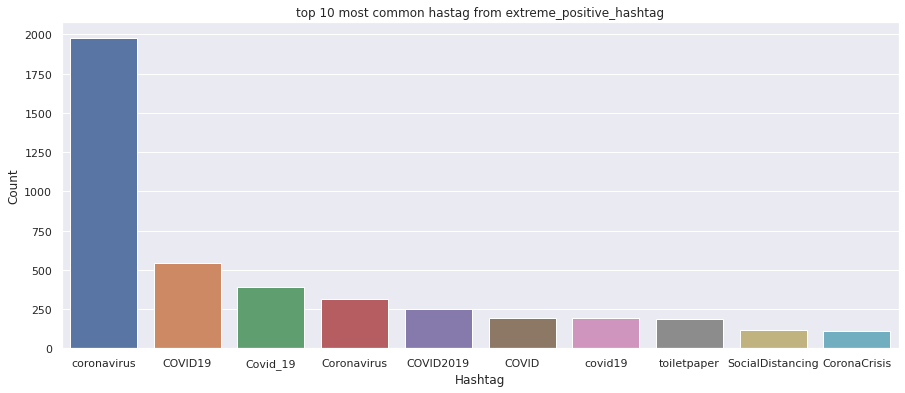

In [60]:
#top 10 most common hastag from extreme_positive_hashtag
hashtag_freq = nltk.FreqDist(extreme_positive_hashtag)
hashtag_freq_df = pd.DataFrame({'Hashtag': list(hashtag_freq.keys()),'Count' : list(hashtag_freq.values())})
top_10_hashtag_freq = hashtag_freq_df.nlargest(10,'Count')
plt.figure(figsize = (15,6))
sns.barplot('Hashtag','Count', data = top_10_hashtag_freq)
plt.title('top 10 most common hastag from extreme_positive_hashtag')
plt.show()

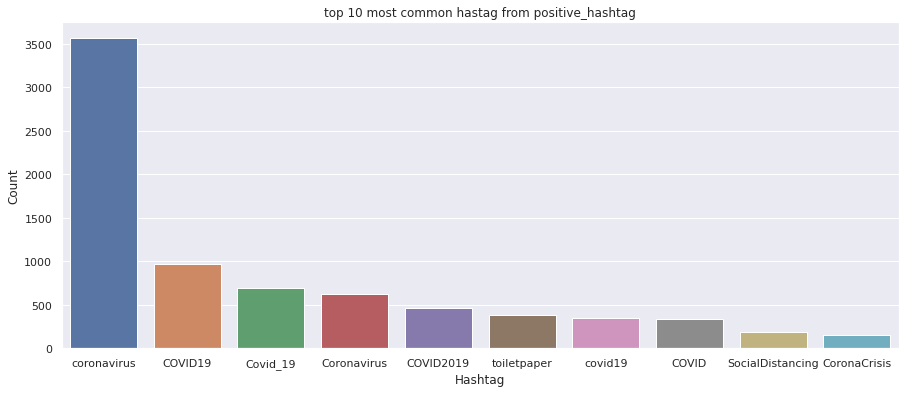

In [61]:
#top 10 most common hastag from positive_hashtag
hashtag_freq = nltk.FreqDist(positive_hashtag)
hashtag_freq_df = pd.DataFrame({'Hashtag': list(hashtag_freq.keys()),'Count' : list(hashtag_freq.values())})
top_10_hashtag_freq = hashtag_freq_df.nlargest(10,'Count')
plt.figure(figsize = (15,6))
sns.barplot('Hashtag','Count', data = top_10_hashtag_freq)
plt.title('top 10 most common hastag from positive_hashtag')
plt.show()

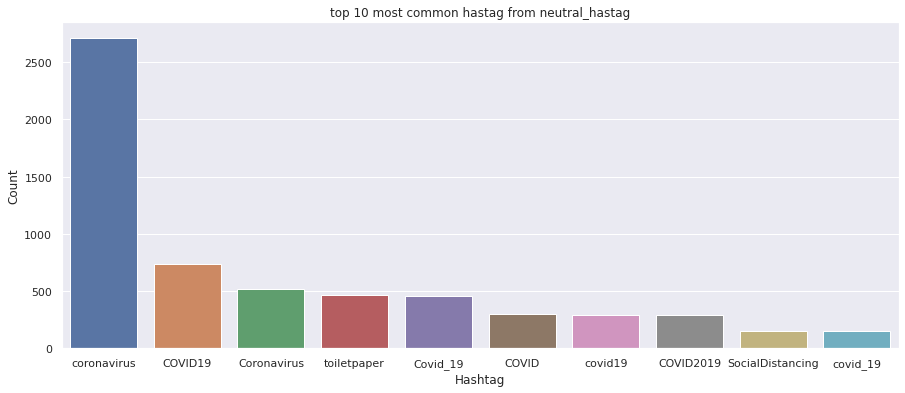

In [62]:
#top 10 most common hastag from neutral_hastag
hashtag_freq = nltk.FreqDist(neutral_hastag)
hashtag_freq_df = pd.DataFrame({'Hashtag': list(hashtag_freq.keys()),'Count' : list(hashtag_freq.values())})
top_10_hashtag_freq = hashtag_freq_df.nlargest(10,'Count')
plt.figure(figsize = (15,6))
sns.barplot('Hashtag','Count', data = top_10_hashtag_freq)
plt.title('top 10 most common hastag from neutral_hastag')
plt.show()

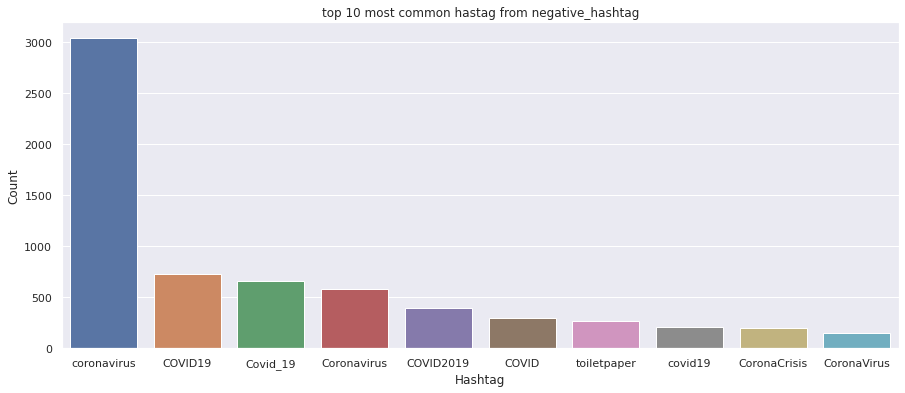

In [63]:
#top 10 most common hastag from negative_hashtag
hashtag_freq = nltk.FreqDist(negative_hashtag)
hashtag_freq_df = pd.DataFrame({'Hashtag': list(hashtag_freq.keys()),'Count' : list(hashtag_freq.values())})
top_10_hashtag_freq = hashtag_freq_df.nlargest(10,'Count')
plt.figure(figsize = (15,6))
sns.barplot('Hashtag','Count', data = top_10_hashtag_freq)
plt.title('top 10 most common hastag from negative_hashtag')
plt.show()

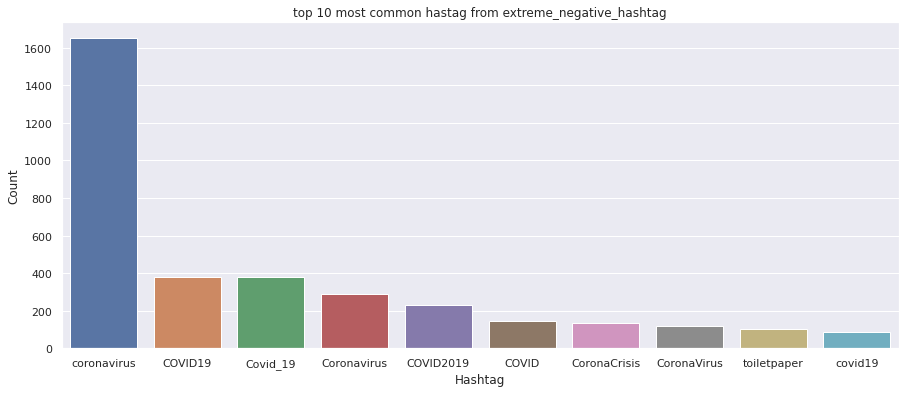

In [64]:
#top 10 most common hastag from extreme_negative_hashtag
hashtag_freq = nltk.FreqDist(extreme_negative_hashtag)
hashtag_freq_df = pd.DataFrame({'Hashtag': list(hashtag_freq.keys()),'Count' : list(hashtag_freq.values())})
top_10_hashtag_freq = hashtag_freq_df.nlargest(10,'Count')
plt.figure(figsize = (15,6))
sns.barplot('Hashtag','Count', data = top_10_hashtag_freq)
plt.title('top 10 most common hastag from extreme_negative_hashtag')
plt.show()

clearly seen in the above figure with all types of sentiment, coronavirus and covid19 with positive trends associated with our dataset

## **Feature Selection**

we have explore all the feature and in our analysis only two feature is important that's why we need to take only two feature cleaned_tweet and Sentiment feature

In [65]:
#only two feature selected for analysis
tweet_data_df = tweet_data[['cleaned_tweet','Sentiment']]

In [66]:
#overview of datset with selected feature
tweet_data_df.head()

,cleaned_tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,Positive
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,Positive
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,Extremely Negative


In [67]:
#how many types of sentiment
tweet_data_df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

**Removing Stopwords**

In [68]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [69]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [70]:
tweet_data_df['cleaned_tweet'].apply(lambda x: [item for item in x if item not in stop])

0                                                                                                                                                                                                             []
1        [v, c,  , l, k,  , u, r,  , n, e, g, h, b, u, r,  , f, l,  , e, x, c, h, n, g,  , p, h, n, e,  , n, u, b, e, r,  , c, r, e,  , c, n, c,  , l,  , w, h,  , p, h, n, e,  , n, u, b, e, r,  , n, e, g, ...
2                                                            [c, r, n, v, r, u,  , u, r, l,  , w, l, w, r, h,  , g, v, e,  , e, l, e, r, l,  , b, l,  , e, c,  , h, p,  , h, u, r,  ,  , c, v,  , u, b, r, e, k]
3        [f,  , c, k,  , n,  , h, e,  , n, l,  , n, e,  , w, h, c, h,  , e, p,  , p, l, e,  , n,  , p, n, c,  , h, e, r, e,  , w, l, l,  , e, n, u, g, h,  , f,  , f, r,  , e, v, e, r, n,  , u,  , n,  , k, ...
4        [r, e,  , u, p, e, r, r, k, e,  , u, r, e,  , h, e,  , #, c, v,  , u, b, r, e, k,  , n,  , b, e, c, u,  , p, r, n,  , b, u,  , b, e, c, u,  , f,  , c, k,  

In [71]:
#overview of datset after removed stop words
tweet_data_df.head()

,cleaned_tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,Positive
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,Positive
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,Extremely Negative


In [72]:
#shape of dataset
tweet_data_df.shape

(41157, 2)

In [73]:
#checking any null value present
tweet_data_df.isna().sum()

cleaned_tweet    0
Sentiment        0
dtype: int64

## **Building Classification Model (Multiclass Classification)**

In [74]:
#assign X as a independent variable and y as a dependent variable
X = tweet_data_df['cleaned_tweet']
y = tweet_data_df['Sentiment']

In [75]:
#spliting dataset into training and testing dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [76]:
#shape of training and testing dataset
print(f'X_train.shape :{X_train.shape}')
print(f'y_train.shape :{y_train.shape}')
print(f'X_test.shape :{X_test.shape}')
print(f'y_test.shape :{y_test.shape}')

X_train.shape :(32925,)
y_train.shape :(32925,)
X_test.shape :(8232,)
y_test.shape :(8232,)


In [77]:
#using counter vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(X_train.values)
X_test = vectorizer.transform(X_test.values)

In [78]:
#shape of training and testing dataset
print(f'X_train.shape :{X_train.shape}')
print(f'y_train.shape :{y_train.shape}')
print(f'X_test.shape :{X_test.shape}')
print(f'y_test.shape :{y_test.shape}')

X_train.shape :(32925, 27104)
y_train.shape :(32925,)
X_test.shape :(8232, 27104)
y_test.shape :(8232,)


* ### **Naive Bayes Classifier**

In [79]:
#Naive Bayes Classifier model
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_test)
NB_train_accuracy = naiveByes_clf.score(X_train,y_train)
NB_accuracy = accuracy_score(y_test,NB_prediction)
print(f'Training accuracy Score    : {NB_train_accuracy}')
print(f'Testing accuracy Score : {NB_accuracy}' )
print(classification_report(NB_prediction,y_test))

Training accuracy Score    : 0.6913287775246773
Testing accuracy Score : 0.4770408163265306
                    precision    recall  f1-score   support

Extremely Negative       0.35      0.61      0.44       624
Extremely Positive       0.43      0.60      0.50       962
          Negative       0.51      0.42      0.46      2411
           Neutral       0.36      0.67      0.47       834
          Positive       0.61      0.41      0.49      3401

          accuracy                           0.48      8232
         macro avg       0.45      0.54      0.47      8232
      weighted avg       0.52      0.48      0.48      8232



* ### **Stochastic Gradient Descent-SGD Classifier**

In [80]:
#Stochastic Gradient Descent-SGD Classifier model
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_test)
sgd_train_accuracy = sgd_clf.score(X_train,y_train)
sgd_accuracy = accuracy_score(y_test,sgd_prediction)
print("training accuracy Score    : ",sgd_train_accuracy)
print("testing accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_test))

training accuracy Score    :  0.8281548974943053
testing accuracy Score :  0.5714285714285714
                    precision    recall  f1-score   support

Extremely Negative       0.66      0.60      0.63      1217
Extremely Positive       0.70      0.64      0.67      1431
          Negative       0.40      0.52      0.45      1499
           Neutral       0.77      0.57      0.66      2057
          Positive       0.48      0.54      0.50      2028

          accuracy                           0.57      8232
         macro avg       0.60      0.58      0.58      8232
      weighted avg       0.60      0.57      0.58      8232



* ### **Random Forest Classifier**

In [81]:
#Random Forest Classifier model
rf_clf = RandomForestClassifier()

rf_clf.fit(X_train, y_train)

rf_prediction = rf_clf.predict(X_test)
rf_train_accuracy = rf_clf.score(X_train,y_train)
rf_accuracy = accuracy_score(y_test,rf_prediction)
print("Training accuracy Score    : ",rf_train_accuracy)
print("Testing accuracy Score : ",rf_accuracy )
print(classification_report(rf_prediction,y_test))

Training accuracy Score    :  0.9962034927866363
Testing accuracy Score :  0.5507774538386784
                    precision    recall  f1-score   support

Extremely Negative       0.36      0.70      0.47       559
Extremely Positive       0.36      0.72      0.48       654
          Negative       0.54      0.51      0.52      2115
           Neutral       0.76      0.59      0.67      1974
          Positive       0.62      0.49      0.55      2930

          accuracy                           0.55      8232
         macro avg       0.53      0.60      0.54      8232
      weighted avg       0.60      0.55      0.56      8232



* ### **Extreme Gradient Boosting**

In [82]:
#Extreme Gradient Boosting model
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier()

xgboost_clf.fit(X_train, y_train)

xgb_prediction = xgboost_clf.predict(X_test)
xgb_train_accuracy = xgboost_clf.score(X_train,y_train)
xgb_accuracy = accuracy_score(y_test,xgb_prediction)
print("Training accuracy Score    : ",xgb_train_accuracy)
print("Testing accuracy Score : ",xgb_accuracy )
print(classification_report(xgb_prediction,y_test))

Training accuracy Score    :  0.5105542900531511
Testing accuracy Score :  0.4871234207968902
                    precision    recall  f1-score   support

Extremely Negative       0.37      0.62      0.47       660
Extremely Positive       0.43      0.73      0.54       780
          Negative       0.38      0.48      0.42      1581
           Neutral       0.59      0.46      0.52      1976
          Positive       0.60      0.43      0.50      3235

          accuracy                           0.49      8232
         macro avg       0.47      0.54      0.49      8232
      weighted avg       0.52      0.49      0.49      8232



* ### **Support vector machine**

In [83]:
#Support vector machine model
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_test)
svc_train_accuracy = svc.score(X_train,y_train)
svc_accuracy = accuracy_score(y_test,svc_prediction)
print("Training accuracy Score    : ",svc_train_accuracy)
print("Testing accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_test))

Training accuracy Score    :  0.898496583143508
Testing accuracy Score :  0.5990038872691934
                    precision    recall  f1-score   support

Extremely Negative       0.46      0.72      0.56       696
Extremely Positive       0.52      0.79      0.63       877
          Negative       0.57      0.54      0.55      2113
           Neutral       0.72      0.63      0.67      1764
          Positive       0.66      0.54      0.59      2782

          accuracy                           0.60      8232
         macro avg       0.58      0.64      0.60      8232
      weighted avg       0.62      0.60      0.60      8232



* ### **Logistic Regression**

In [84]:
#Logistic Regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_test)
logreg_train_accuracy = logreg.score(X_train,y_train)
logreg_accuracy = accuracy_score(y_test,logreg_prediction)
print("Training accuracy Score    : ",logreg_train_accuracy)
print("Testing accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_test))

Training accuracy Score    :  0.8880182232346241
Testing accuracy Score :  0.6161321671525753
                    precision    recall  f1-score   support

Extremely Negative       0.56      0.67      0.61       919
Extremely Positive       0.64      0.71      0.67      1196
          Negative       0.58      0.55      0.56      2072
           Neutral       0.73      0.63      0.68      1776
          Positive       0.59      0.59      0.59      2269

          accuracy                           0.62      8232
         macro avg       0.62      0.63      0.62      8232
      weighted avg       0.62      0.62      0.62      8232



* ### **Catboost Model**

In [85]:
#installing catboot
!pip install catboost

In [86]:
#Catboost Model
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

clf2 = CatBoostClassifier()

clf2.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False )

print('CatBoost model is fitted: ' + str(clf2.is_fitted()))
print('CatBoost model parameters:')
print(clf2.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{}


In [87]:
#Catboost Model accuracy
catboost_prediction = clf2.predict(X_test)
catboost_train_accuracy = clf2.score(X_train,y_train)
catboost_accuracy = accuracy_score(y_test,catboost_prediction)
print("Training accuracy Score    : ",catboost_train_accuracy)
print("Testing accuracy Score : ",catboost_accuracy )
print(classification_report(catboost_prediction,y_test))

Training accuracy Score    :  0.670250569476082
Testing accuracy Score :  0.6171039844509232
                    precision    recall  f1-score   support

Extremely Negative       0.52      0.71      0.60       802
Extremely Positive       0.56      0.78      0.65       962
          Negative       0.53      0.57      0.55      1847
           Neutral       0.81      0.59      0.68      2107
          Positive       0.64      0.58      0.61      2514

          accuracy                           0.62      8232
         macro avg       0.61      0.65      0.62      8232
      weighted avg       0.64      0.62      0.62      8232



* ### **Comparison of all multiclass models test accuracy**

In [89]:
#Comparison of all multiclass models test accuracy
all_multiclass_models = pd.DataFrame({'Model': ['Support Vector Machines', 'Logistic Regression', 'Random Forest', 'Naive Bayes', 
                                               'Stochastic Gradient Decent', 'XGBoost','CatBoost'],
                                   'Test accuracy': [svc_accuracy, logreg_accuracy, rf_accuracy, NB_accuracy, 
                                                sgd_accuracy, xgb_accuracy,catboost_accuracy],
                                  'Train accuracy': [svc_train_accuracy, logreg_train_accuracy, rf_train_accuracy, NB_train_accuracy, 
                                         sgd_train_accuracy, xgb_train_accuracy,catboost_train_accuracy]})

all_multiclass_models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy,Train accuracy
6,CatBoost,0.617104,0.670251
1,Logistic Regression,0.616132,0.888018
0,Support Vector Machines,0.599004,0.898497
4,Stochastic Gradient Decent,0.571429,0.828155
2,Random Forest,0.550777,0.996203
5,XGBoost,0.487123,0.510554
3,Naive Bayes,0.477041,0.691329


## **Building Classification Model (Binary Classification)**

In [90]:
#Encoded multiclass to Binary class
tweet_data_encoded = tweet_data_df.copy()

tweet_data_encoded["Sentiment"]= tweet_data_encoded["Sentiment"].replace('Positive',1) 
tweet_data_encoded["Sentiment"]= tweet_data_encoded["Sentiment"].replace('Extremely Positive',1) 
tweet_data_encoded["Sentiment"]= tweet_data_encoded["Sentiment"].replace('Neutral',1) 
tweet_data_encoded["Sentiment"]= tweet_data_encoded["Sentiment"].replace('Negative',0) 
tweet_data_encoded["Sentiment"]= tweet_data_encoded["Sentiment"].replace('Extremely Negative',0) 

In [91]:
#assign X as a independent variable and y as a dependent variable
X = tweet_data_encoded['cleaned_tweet']
y = tweet_data_encoded['Sentiment']

In [92]:
#spliting dataset into training and testing dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [93]:
#shape of training and testing dataset
print(f'X_train.shape :{X_train.shape}')
print(f'y_train.shape :{y_train.shape}')
print(f'X_test.shape :{X_test.shape}')
print(f'y_test.shape :{y_test.shape}')

X_train.shape :(32925,)
y_train.shape :(32925,)
X_test.shape :(8232,)
y_test.shape :(8232,)


In [94]:
#using counter vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(X_train.values)
X_test = vectorizer.transform(X_test.values)

In [95]:
#shape of training and testing dataset
print(f'X_train.shape :{X_train.shape}')
print(f'y_train.shape :{y_train.shape}')
print(f'X_test.shape :{X_test.shape}')
print(f'y_test.shape :{y_test.shape}')

X_train.shape :(32925, 27187)
y_train.shape :(32925,)
X_test.shape :(8232, 27187)
y_test.shape :(8232,)


* ### **Naive Bayes Classifier**

In [96]:
#Naive Bayes Classifier model
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_test)
NB_train_accuracy = naiveByes_clf.score(X_train,y_train)
NB_accuracy = accuracy_score(y_test,NB_prediction)
print(f'Training accuracy Score    : {NB_train_accuracy}')
print(f'Testing accuracy Score : {NB_accuracy}' )
print(classification_report(NB_prediction,y_test))

Training accuracy Score    : 0.8570994684889901
Testing accuracy Score : 0.7860787172011662
              precision    recall  f1-score   support

           0       0.69      0.72      0.71      2949
           1       0.84      0.82      0.83      5283

    accuracy                           0.79      8232
   macro avg       0.77      0.77      0.77      8232
weighted avg       0.79      0.79      0.79      8232



* ### **Stochastic Gradient Descent-SGD Classifier**

In [97]:
#Stochastic Gradient Descent-SGD Classifier model
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_test)
sgd_train_accuracy = sgd_clf.score(X_train,y_train)
sgd_accuracy = accuracy_score(y_test,sgd_prediction)
print("training accuracy Score    : ",sgd_train_accuracy)
print("testing accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_test))

training accuracy Score    :  0.9341837509491268
testing accuracy Score :  0.8626093294460642
              precision    recall  f1-score   support

           0       0.77      0.85      0.81      2795
           1       0.92      0.87      0.89      5437

    accuracy                           0.86      8232
   macro avg       0.84      0.86      0.85      8232
weighted avg       0.87      0.86      0.86      8232



* ### **Random Forest Classifier**

In [98]:
#Random Forest Classifier model
rf_clf = RandomForestClassifier()

rf_clf.fit(X_train, y_train)

rf_prediction = rf_clf.predict(X_test)
rf_train_accuracy = rf_clf.score(X_train,y_train)
rf_accuracy = accuracy_score(y_test,rf_prediction)
print("Training accuracy Score    : ",rf_train_accuracy)
print("Testing accuracy Score : ",rf_accuracy )
print(classification_report(rf_prediction,y_test))

Training accuracy Score    :  0.9984813971146546
Testing accuracy Score :  0.8231292517006803
              precision    recall  f1-score   support

           0       0.70      0.80      0.75      2672
           1       0.90      0.83      0.86      5560

    accuracy                           0.82      8232
   macro avg       0.80      0.82      0.81      8232
weighted avg       0.83      0.82      0.83      8232



* ### **Extreme Gradient Boosting**

In [99]:
#Extreme Gradient Boosting model
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier()

xgboost_clf.fit(X_train, y_train)

xgb_prediction = xgboost_clf.predict(X_test)
xgb_train_accuracy = xgboost_clf.score(X_train,y_train)
xgb_accuracy = accuracy_score(y_test,xgb_prediction)
print("Training accuracy Score    : ",xgb_train_accuracy)
print("Testing accuracy Score : ",xgb_accuracy )
print(classification_report(xgb_prediction,y_test))

Training accuracy Score    :  0.747213363705391
Testing accuracy Score :  0.7465986394557823
              precision    recall  f1-score   support

           0       0.40      0.85      0.54      1440
           1       0.96      0.73      0.83      6792

    accuracy                           0.75      8232
   macro avg       0.68      0.79      0.68      8232
weighted avg       0.86      0.75      0.78      8232



* ### **Support vector machine**

In [100]:
#Support vector machine model
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_test)
svc_train_accuracy = svc.score(X_train,y_train)
svc_accuracy = accuracy_score(y_test,svc_prediction)
print("Training accuracy Score    : ",svc_train_accuracy)
print("Testing accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_test))

Training accuracy Score    :  0.9565679574791192
Testing accuracy Score :  0.8368561710398446
              precision    recall  f1-score   support

           0       0.68      0.85      0.76      2479
           1       0.93      0.83      0.88      5753

    accuracy                           0.84      8232
   macro avg       0.81      0.84      0.82      8232
weighted avg       0.85      0.84      0.84      8232



* ### **Logistic Regression**

In [101]:
#Logistic Regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_test)
logreg_train_accuracy = logreg.score(X_train,y_train)
logreg_accuracy = accuracy_score(y_test,logreg_prediction)
print("Training accuracy Score    : ",logreg_train_accuracy)
print("Testing accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_test))

Training accuracy Score    :  0.9384662110858011
Testing accuracy Score :  0.8610301263362488
              precision    recall  f1-score   support

           0       0.77      0.85      0.81      2802
           1       0.92      0.87      0.89      5430

    accuracy                           0.86      8232
   macro avg       0.84      0.86      0.85      8232
weighted avg       0.87      0.86      0.86      8232



* ### **Catboost Model**

In [102]:
#Catboost Model
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

clf2 = CatBoostClassifier()

clf2.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False )

print('CatBoost model is fitted: ' + str(clf2.is_fitted()))
print('CatBoost model parameters:')
print(clf2.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{}


In [103]:
#Catboost Model accuracy
catboost_prediction = clf2.predict(X_test)
catboost_train_accuracy = clf2.score(X_train,y_train)
catboost_accuracy = accuracy_score(y_test,catboost_prediction)
print("Training accuracy Score    : ",catboost_train_accuracy)
print("Testing accuracy Score : ",catboost_accuracy )
print(classification_report(catboost_prediction,y_test))

Training accuracy Score    :  0.8847987851176917
Testing accuracy Score :  0.8486394557823129
              precision    recall  f1-score   support

           0       0.72      0.85      0.78      2586
           1       0.93      0.85      0.88      5646

    accuracy                           0.85      8232
   macro avg       0.82      0.85      0.83      8232
weighted avg       0.86      0.85      0.85      8232



* ### **Comparison of all Binary class models test accuracy**

In [104]:
#Comparison of all Binary class models test accuracy
all_binaryclass_models = pd.DataFrame({'Model': ['Support Vector Machines', 'Logistic Regression', 'Random Forest', 'Naive Bayes', 
                                                 'Stochastic Gradient Decent', 'XGBoost','CatBoost'],
                                    'Test accuracy': [svc_accuracy, logreg_accuracy, rf_accuracy, NB_accuracy, 
                                                  sgd_accuracy, xgb_accuracy,catboost_accuracy],
                                   'Train accuracy': [svc_train_accuracy, logreg_train_accuracy, rf_train_accuracy, NB_train_accuracy, 
                                                  sgd_train_accuracy, xgb_train_accuracy,catboost_train_accuracy]})

all_binaryclass_models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy,Train accuracy
4,Stochastic Gradient Decent,0.862609,0.934184
1,Logistic Regression,0.861030,0.938466
6,CatBoost,0.848639,0.884799
0,Support Vector Machines,0.836856,0.956568
2,Random Forest,0.823129,0.998481
3,Naive Bayes,0.786079,0.857099
5,XGBoost,0.746599,0.747213


* ### **Hyperparameter Tunning**

In [105]:
#Hyperparameter tunning for LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}
accuracy : 0.8544570315397108


In [107]:
#accuracy after hyperparameter tunning
logreg_cv_prediction = logreg_cv.predict(X_test)
logreg_cv_accuracy = accuracy_score(y_test,logreg_cv_prediction)
print("Training accuracy Score    : ",logreg_cv.score(X_train,y_train))
print("Testing accuracy Score : ",logreg_cv_accuracy )
print(classification_report(logreg_cv_prediction,y_test))

Training accuracy Score    :  0.9384662110858011
Testing accuracy Score :  0.8610301263362488
              precision    recall  f1-score   support

           0       0.77      0.85      0.81      2802
           1       0.92      0.87      0.89      5430

    accuracy                           0.86      8232
   macro avg       0.84      0.86      0.85      8232
weighted avg       0.87      0.86      0.86      8232



* not any remarkable result in hyperparameter tunning

## **Model Selection**

* **Multiclass classification**

In [108]:
# all_multiclass_models in sorted order
all_multiclass_models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy,Train accuracy
6,CatBoost,0.617104,0.670251
1,Logistic Regression,0.616132,0.888018
0,Support Vector Machines,0.599004,0.898497
4,Stochastic Gradient Decent,0.571429,0.828155
2,Random Forest,0.550777,0.996203
5,XGBoost,0.487123,0.510554
3,Naive Bayes,0.477041,0.691329


**According to the test and training accuracy we select Logistic Regression model for multiclass classification**

* **Binary class classification**

In [109]:
# all_binaryclass_models in sorted order
all_binaryclass_models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy,Train accuracy
4,Stochastic Gradient Decent,0.862609,0.934184
1,Logistic Regression,0.861030,0.938466
6,CatBoost,0.848639,0.884799
0,Support Vector Machines,0.836856,0.956568
2,Random Forest,0.823129,0.998481
3,Naive Bayes,0.786079,0.857099
5,XGBoost,0.746599,0.747213


**According to the test accuracy we select Stochastic Gradient Decent model for Binaryclass classification**

# **Conclusion**
Out of Seven models, the best model for this dataset would be Logistic Regression, For multiclass classification.

For binary classification, the best model for this dataset would be Stochastic Gradient Descent.
